In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import abd_profile
import os
import pandas as pd
import GCN
import copy
import numpy as np
import tree_util
import se
from scipy.stats import mannwhitneyu
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.stats.multitest import fdrcorrection as fdr
import json

In [2]:
outer = '../result/GCN_fix_tree'
outdir = '../result/immu/SE'
ori_GCN = GCN.input_GCN('../data/gcn2008.tsv', transfer=True)
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
with open(os.path.join(outer, 'renamed_GCN_tree.newick')) as fp:
    newick_tree = fp.read()

In [3]:
json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
renamed_GCN = ori_GCN[list(d_df.columns)].rename(columns=name_dict)
renamed_d = d_df.rename(columns=name_dict, index=name_dict)
result = {}
# compute leaf layer
result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

In [4]:
result['leaves_dict']['root'] = {'root': list(name_dict.values())}
node_leaves['root'] = list(name_dict.values())

In [5]:
def fr(d_df, profile, sname):
    #print(profile.columns, d_df.index)
    sp_list = list(set(profile.columns).intersection(set(d_df.index)))
    #print(sp_list)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    fr_df = pd.DataFrame(value, index=sp_list, columns=sp_list)
    return fr_df

def multisample_se(profile, d_df, parent_dict, node_leaves, child_dict, direct_children_dict, param):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys())))
    for sname in profile.index:
        # print(sname)
        edge_df = fr(d_df, profile, sname)
        tmp = se.subtree_se_adj(edge_df, parent_dict, node_leaves, child_dict, direct_children_dict, param)
        for node in tmp.keys():
                value = tmp[node]
                result.loc[sname, node] = value
    return result


In [6]:
def main(indir, GCN_df, sp_d, result, name_dict, parent_dict, node_leaves, child_dict, direct_children_dict, param, cohort):
    #input dir: including metadata.tsv and abd.tsv
    # output result to dir
    abd_path = os.path.join(indir, 'merged_species.txt')
    metadata_path = os.path.join(indir, 'metadata.txt')

    # first process data from gutmeta
    raw_profile = abd_profile.input_profile(abd_path, transfer=True)
    metadata = pd.read_csv(metadata_path, sep=',', header=0)
    metadata.fillna('NA', inplace=True)
    metadata = metadata[(metadata['Cohort'] == cohort)] #  
    metadata = metadata[metadata['Sample Name'].isin(list(raw_profile.index))]
    

    selected_raw_profile = raw_profile.loc[list(metadata['Sample Name']), :]
    
    crc_profile = abd_profile.check(selected_raw_profile, GCN_df, name_dict)
    column_medians = crc_profile.median()
    for sp in crc_profile.columns:
        crc_profile.loc[:, sp] = crc_profile.loc[:, sp] - column_medians[sp]
    crc_profile[crc_profile > 0] = 1
    crc_profile[crc_profile < 0] = 0

    pheno_list = {}
    pheno_profiles = {}
    for i in metadata.index:
        pheno = metadata.loc[i, 'OS12']
        if pheno == 'NA':
            continue
        if pheno not in pheno_list.keys():
            pheno_list[pheno] = []
        if metadata.loc[i, 'Sample Name'] in list(crc_profile.index):
            pheno_list[pheno].append(metadata.loc[i, 'Sample Name'])

    for c, clist in pheno_list.items():
        pheno_profiles[c] = copy.deepcopy(crc_profile.loc[clist, :])
    # seperate by enterotypes

    
    level_se_result = {}   
    for p, profile in pheno_profiles.items():
        p_result = multisample_se(profile, sp_d, parent_dict, node_leaves, child_dict, direct_children_dict, param)
        for level, cluster_sp_dict in result['leaves_dict'].items():
            if level not in level_se_result.keys():
                level_se_result[level] = {}
            l_se = p_result.loc[:, list(cluster_sp_dict.keys())]
            level_se_result[level][p] = copy.deepcopy(l_se)
 
    return level_se_result

In [7]:
se_result = {}
outer = '../data'
cohort_list = ['Disc', 'Valid'] 
param = 0.5
indir= os.path.join(outer, 'immu')


In [8]:
se_result = {}
for cohort in cohort_list:
    level_b = main(indir, renamed_GCN, renamed_d, result, name_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict, param, cohort)
    se_result[cohort] = copy.deepcopy(level_b)


different sp: {'s__Ruminococcus_champanellensis', 's__Sutterella_parvirubra', 's__Collinsella_stercoris', 's__[Collinsella]_massiliensis', 's__Granulicatella_elegans', 's__Candida_albicans', 's__Bacillus_circulans', 's__Blastocystis_sp_subtype_1', 's__Gemella_bergeri', 's__Olsenella_profusa', 's__Bulleidia_extructa', 's__Cloacibacillus_evryensis', 's__Campylobacter_peloridis', 's__Saccharomyces_cerevisiae', 's__Giardia_intestinalis'}
!!!difference species are deleted
different sp: {'s__Ruminococcus_champanellensis', 's__Sutterella_parvirubra', 's__Collinsella_stercoris', 's__[Collinsella]_massiliensis', 's__Granulicatella_elegans', 's__Candida_albicans', 's__Bacillus_circulans', 's__Blastocystis_sp_subtype_1', 's__Gemella_bergeri', 's__Olsenella_profusa', 's__Bulleidia_extructa', 's__Cloacibacillus_evryensis', 's__Campylobacter_peloridis', 's__Saccharomyces_cerevisiae', 's__Giardia_intestinalis'}
!!!difference species are deleted


In [9]:
def output_se(se_result, outdir, cohort):
    odir = os.path.join(outdir, cohort)
    if not os.path.exists(odir):
        os.makedirs(odir)
    
    phenos = list(se_result[cohort]['root'].keys())
    
    for pheno in phenos:
        pheno_df = pd.DataFrame()
        for level, level_result in se_result[cohort].items():
            pheno_result = level_result[pheno]
            for node in pheno_result.columns:
                if node not in pheno_df.columns:
                    for sname in pheno_result.index:
                        pheno_df.loc[sname, node] = pheno_result.loc[sname, node]
        pheno_df.to_csv(os.path.join(odir, 'se_{}.tsv'.format(pheno)), sep='\t')

In [10]:
for cohort in se_result.keys():
    output_se(se_result, outdir, cohort)

In [16]:
if not os.path.exists(outdir):
    os.makedirs(outdir)
p_cutoff = 0.05


p_df = pd.DataFrame()
mean_df = pd.DataFrame()
valid_dict = {}
show_node = []
for level in result['leaves_dict'].keys():
    for cohort in se_result.keys():
        
        if 'NR' not in se_result[cohort][level].keys():
            continue
        if 'R' not in se_result[cohort][level].keys():
            continue
        if cohort not in valid_dict.keys():
            valid_dict[cohort] = []
        l_se1 = se_result[cohort][level]['NR']
        l_se2 = se_result[cohort][level]['R']
        for inode in l_se1.columns:
            if (list(l_se1[inode]).count(0) > len(list(l_se1[inode]))*0.8) and (list(l_se2[inode]).count(0) > len(list(l_se2[inode]))*0.8):
                continue
            valid_dict[cohort].append(inode)
            t, p1 = mannwhitneyu(list(l_se1[inode]), list(l_se2[inode]))
            p_df.loc[cohort, inode] = p1
            mean_df.loc[cohort, inode] = np.mean(l_se1[inode]) - np.mean(l_se2[inode])
p_df.fillna(np.nan, inplace=True)

In [1]:
for dir in p_df.index:
    valid_nodes = valid_dict[dir]
    p_vector = list(p_df.loc[dir, valid_nodes])
    p_adj = fdr(p_vector, p_cutoff)[1]
    for i, node in enumerate(valid_nodes):
        p_df.loc[dir, node] = p_adj[i]
p_df.to_csv(os.path.join(outdir, 'p_all_cohorts.tsv'), sep='\t')

NameError: name 'p_df' is not defined

In [2]:
node_plot = pd.DataFrame()
for dir in p_df.index:
    for inode in p_df.columns:
        p1 = p_df.loc[dir, inode]
        if pd.isna(p1):
            node_plot.loc[dir, inode] = np.nan
        elif p1 < p_cutoff:
            if mean_df.loc[dir, inode] > 0:
                node_plot.loc[dir, inode] = 1
            else:
                node_plot.loc[dir, inode] = -1
        else:
            node_plot.loc[dir, inode] = 0


NameError: name 'pd' is not defined

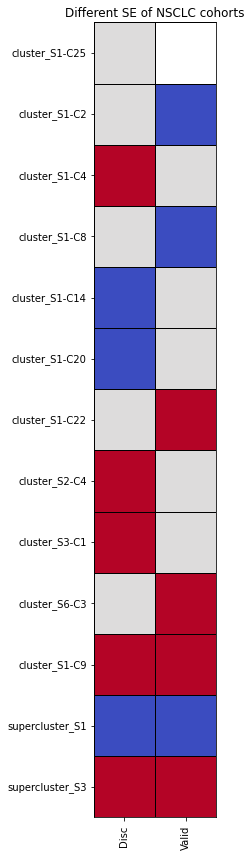

In [18]:
show_node = []   
part_df = node_plot
for inode in part_df.columns:
    all_zero = True
    all_nan = True
    for dir in part_df.index:
        if not pd.isna(node_plot.loc[dir, inode]):
            all_nan = False
        if node_plot.loc[dir, inode] != 0:
            all_zero = False
    if not (all_zero or all_nan):
        show_node.append(inode)
plt.figure(figsize=(5, 12))
part_df = part_df[show_node]
non_zero_count = part_df.astype(bool).sum(axis=0) - part_df.isnull().sum(axis=0)
sorted_df = part_df.iloc[:, non_zero_count.argsort()]
#show_node = sorted(show_node)
sns.heatmap(sorted_df.T, vmax=1, vmin=-1, square=True, linecolor='black', cbar=False, xticklabels=True, yticklabels=True, linewidths=1, cmap="coolwarm")
plt.title('Different SE of NSCLC cohorts')
plt.xticks(rotation=90)
ax = plt.gca()

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
opath = os.path.join(outdir, 'NSCLC.pdf')
plt.tight_layout()
plt.savefig(opath, dpi=300, format='pdf')
part_df[show_node].to_csv(os.path.join(outdir, 'NSCLC.tsv'), sep='\t')
#plt.show()
#print(part_df[show_node].shape)

In [15]:
p_df

,cluster_S1-C1,cluster_S1-C2,cluster_S1-C3,cluster_S1-C4,cluster_S1-C5,cluster_S1-C8,cluster_S1-C9,cluster_S1-C10,cluster_S1-C13,cluster_S1-C14,...,cluster_S3-C1,cluster_S3-C3,cluster_S6-C1,cluster_S6-C3,supercluster_S1,supercluster_S2,supercluster_S3,supercluster_S5,supercluster_S6,root
Disc,0.546276,0.234367,0.503831,0.165932,0.805792,0.948624,0.051103,0.234367,0.234367,0.165932,...,0.165932,0.176430,0.473129,0.234367,0.165932,0.694259,0.051103,0.384006,0.948624,0.948624
Valid,0.399307,0.002013,0.399307,0.278469,0.278469,0.153441,0.079786,0.399307,0.399307,0.238535,...,0.231245,0.512453,0.790357,0.153441,0.109603,0.231245,0.079786,0.238535,0.399307,0.744178
